# Project 1

## Goal of the analysis:

__Hypothesis:__  Counties with higher migration flows and high population density will exhibit higher infection rates of COVID-19.

__Goal of this analysis:__ Investigate the relationship between migration rates, population density, and COVID-19 infection rates, aiming to determine if a statistically significant correlation exists. Additionally, to identify counties or factors where the relationship appears to be particularly strong, providing insights into the impact of migration and population density on COVID-19 infection rates at a local level.



## Clearly state what the measurement is and the two factors 

* __Measurement:__ Infection rate
* __F1:__ Migration gross flow
* __F2:__ Population density


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Available data: obtained from CENSUS.gov

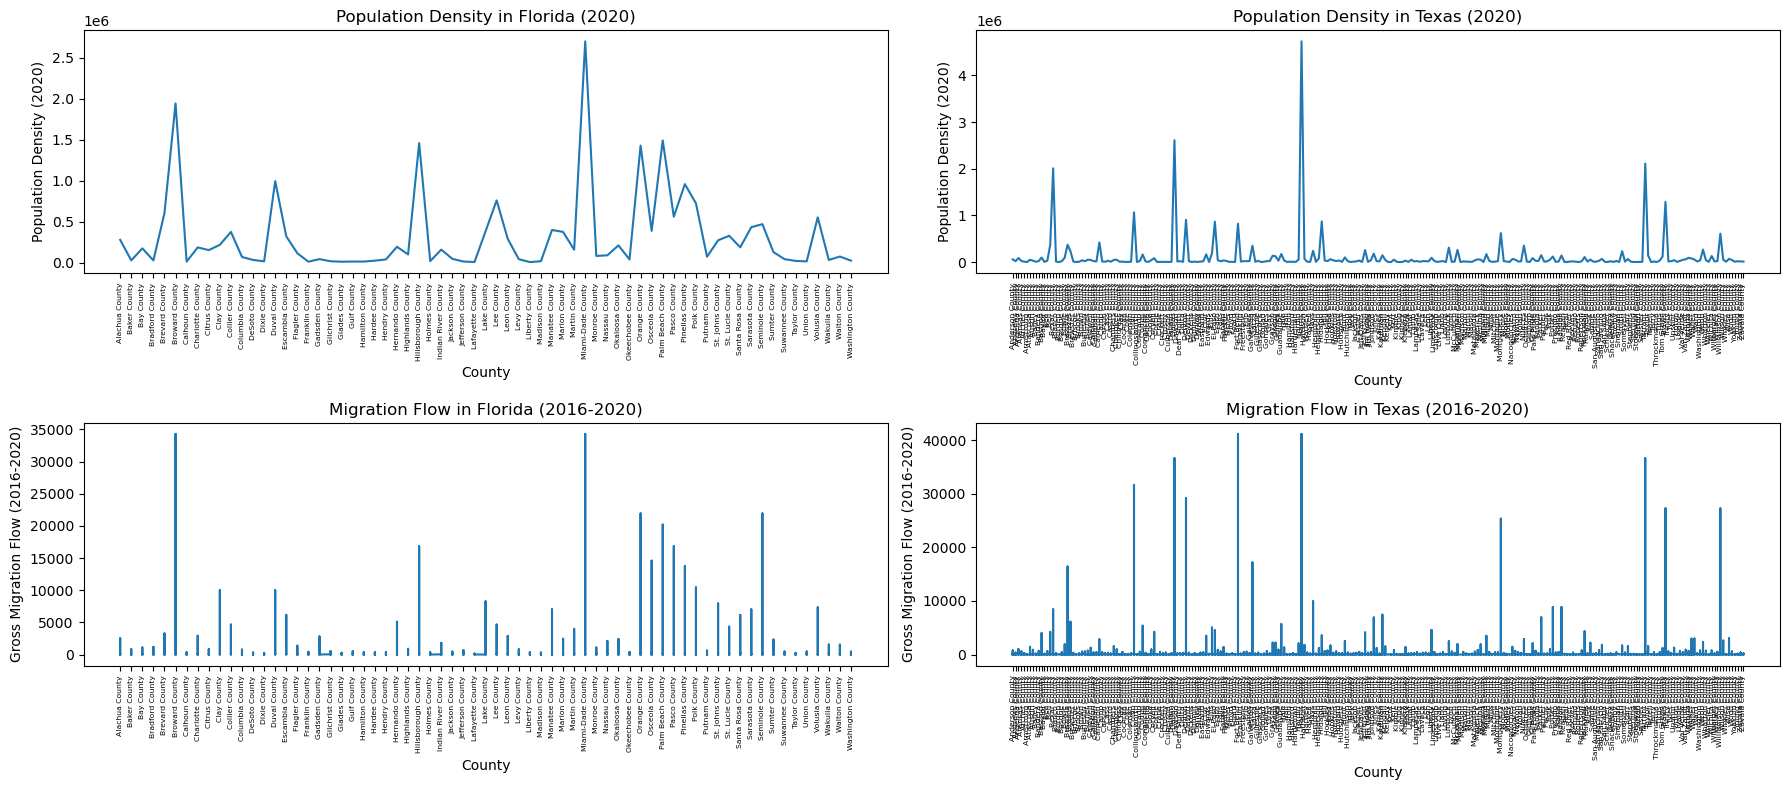

In [2]:
pop_file = "population.xlsx"
mig_file = "migration_flow.xlsx"

# I selected two states and all their counties for analysis.
states = ["Florida", "Texas"]
pop_data = pd.read_excel(pop_file, sheet_name="population_filtered", engine='openpyxl')
mig_data = pd.read_excel(mig_file, sheet_name="migrationflow_filtered", engine='openpyxl')
#plot
fig, axes = plt.subplots(2, len(states), figsize=(18, 8))
for i, state in enumerate(states):
    ax1 = axes[0, i]
    state_pop = pop_data[pop_data['STNAME'] == state]
    ax1.plot(state_pop['CTYNAME'], state_pop['ESTIMATESBASE2020'])
    ax1.set_title(f"Population Density in {state} (2020)")
    ax1.set_xlabel("County")
    ax1.set_ylabel("Population Density (2020)")
    ax1.tick_params(axis='x', rotation=90, labelsize=5.5)
    
    ax2 = axes[1, i]
    state_mig = mig_data[mig_data['STNAME'] == state]
    ax2.plot(state_mig['CTYNAME'], state_mig['GROSSMIG'])
    ax2.set_title(f"Migration Flow in {state} (2016-2020)")
    ax2.set_xlabel("County")
    ax2.set_ylabel("Gross Migration Flow (2016-2020)")
    ax2.tick_params(axis='x', rotation=90, labelsize=5.5)

plt.tight_layout();

In [3]:
df = pd.read_csv("us-counties-2020.csv")

In [4]:
filtered_data = df[df['state'].isin(["Florida", "Texas"])]

In [5]:
#Filtered data
grouped_data = filtered_data.groupby(['state', 'county'])
sum_cases_by_county = grouped_data['cases'].sum().reset_index()
#sum_cases_by_county

In [6]:
## population density data
df_2 = pd.read_csv('pop.csv')
columns_to_keep = ['State','NAME', 'B01001_calc_PopDensity']
df_2 = df_2[columns_to_keep]

In [7]:
#create a condensed dataframe
#rate of infection calculation
sum_cases_by_county['rate of infection'] = sum_cases_by_county['cases'] / pop_data['ESTIMATESBASE2020']
sum_cases_by_county['migration flow'] = mig_data['GROSSMIG']
sum_cases_by_county['population density'] = df_2['B01001_calc_PopDensity']
#print(sum_cases_by_county)
nan_count = sum_cases_by_county.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {nan_count}")

Total NaN values in the DataFrame: 4


In [8]:
sum_cases_by_county.dropna(inplace=True)

In [9]:
#high migration flow?
average_mig_flow = sum_cases_by_county['migration flow'].mean()

print(f"Average Mig Flow: {average_mig_flow}")
def binary(value):
    if value > average_mig_flow:
        return 1
    else:
        return 0
sum_cases_by_county['mig flow_binary'] = sum_cases_by_county['migration flow'].apply(binary)

Average Mig Flow: 142.09657320872273


In [21]:
sum_cases_by_county['roi'] = np.log1p(sum_cases_by_county['rate of infection'])
sum_cases_by_county['pd'] = np.log1p(sum_cases_by_county['population density'])

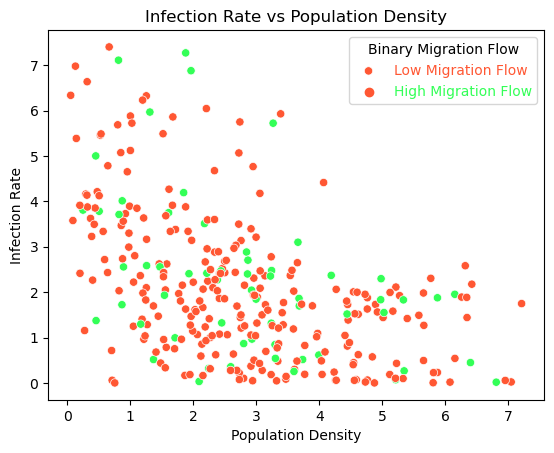

In [11]:
custom_palette = sns.color_palette(["#FF5733", "#33FF57"]) 
sns.scatterplot(x='pd', y='roi', hue='mig flow_binary', data=sum_cases_by_county, palette=custom_palette)
plt.title('Infection Rate vs Population Density')
plt.xlabel('Population Density')
plt.ylabel('Infection Rate')

custom_legend_labels = {0: 'Low Migration Flow', 1: 'High Migration Flow'}
legend = plt.legend(title='Binary Migration Flow', labels=[custom_legend_labels[0], custom_legend_labels[1]], loc='upper right')
for i, label in enumerate(legend.get_texts()):
    label.set_color(custom_palette[i])
plt.show()

r_i = -4.98e-01*pd + 2.57e-01*mf + 3.44e+00
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     51.37
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           4.64e-20
Time:                        21:28:35   Log-Likelihood:                -568.48
No. Observations:                 321   AIC:                             1143.
Df Residuals:                     318   BIC:                             1154.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

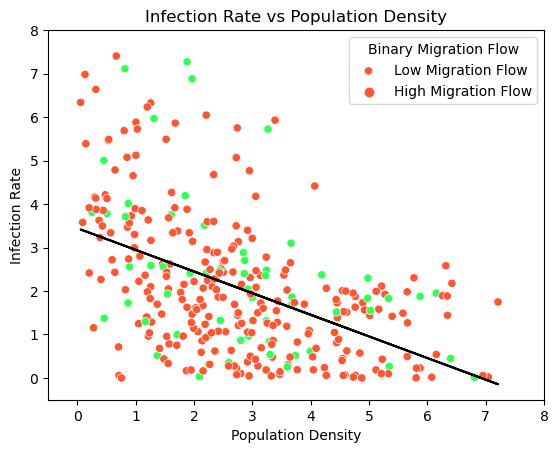

In [22]:
X = np.c_[np.ones(321), sum_cases_by_county['pd'], sum_cases_by_county['mig flow_binary']]
tmp = np.linalg.inv(np.matmul(np.transpose(X), X))
result1 = tmp @ np.transpose(X) @ sum_cases_by_county['roi']
print(f'r_i = {result1[1]:0.2e}*pd + {result1[2]:0.2e}*mf + {result1[0]:0.2e}')

X_2 = sum_cases_by_county[['pd', 'mig flow_binary']]
X_3 = sm.add_constant(X_2)
y_2 = sum_cases_by_county['roi']
model = sm.OLS(y_2, X_3).fit()
results = model.summary()
print(results)
slope = model.params['pd']
intercept = model.params['const']

Set_2 = sns.color_palette(["#FF5733", "#33FF57"])
sns.scatterplot(x='pd', y='roi', hue='mig flow_binary', data=sum_cases_by_county, palette=Set_2)
x_values = sum_cases_by_county['pd']
linear_regression_line = slope * x_values + intercept
plt.plot(x_values, linear_regression_line, color='black', label='Linear Regression Line')

plt.title('Infection Rate vs Population Density')
plt.xlabel('Population Density')
plt.ylabel('Infection Rate')
plt.ylim(-0.5, 8)  
plt.xlim(-0.5, 8)  

custom_legend_labels_2 = {0: 'Low Migration Flow', 1: 'High Migration Flow'}
legend_2 = plt.legend(title='Binary Migration Flow', labels=[custom_legend_labels_2[0], custom_legend_labels_2[1]], loc='upper right')
for i, label in enumerate(legend.get_texts()):
    label.set_color(custom_palette[i])
plt.show()

In [13]:
sum_cases_by_county['Interaction Term'] = sum_cases_by_county['pd'] * sum_cases_by_county['mig flow_binary']

X_4 = sum_cases_by_county[['pd', 'mig flow_binary', 'Interaction Term']]
X_5= sm.add_constant(X_4)

y_3 = sum_cases_by_county['roi']
model_2 = sm.OLS(y_3, X_5).fit()
results_2 = model_2.summary()
print(results_2)

                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     34.14
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           3.78e-19
Time:                        21:20:59   Log-Likelihood:                -568.47
No. Observations:                 321   AIC:                             1145.
Df Residuals:                     317   BIC:                             1160.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4502      0.175  

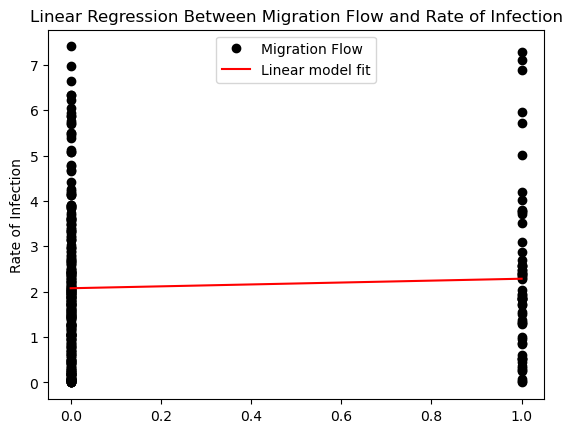

In [14]:
X_m = np.c_[np.ones(len(sum_cases_by_county)), sum_cases_by_county['mig flow_binary']]
y_m = sum_cases_by_county['roi']

X_m = sm.add_constant(X_m)
model = sm.OLS(y_m, X_m).fit()
INTERCEPT2, SLOPE2 = model.params[0], model.params[1]

tempx2 = [0, 1]
plotting_temp2 = [SLOPE2 * x + INTERCEPT2 for x in tempx2]

plt.plot(sum_cases_by_county['mig flow_binary'], sum_cases_by_county['roi'], 'ko')
plt.plot(tempx2, plotting_temp2, 'r-')

plt.ylabel('Rate of Infection')
plt.title('Linear Regression Between Migration Flow and Rate of Infection')
plt.legend(['Migration Flow', 'Linear model fit'])
plt.show()


In [17]:
X_mig_flow = sum_cases_by_county['mig flow_binary']
X_mig_flow = sm.add_constant(X_mig_flow)

model_mig_flow = sm.OLS(y_m, X_mig_flow).fit()

print("Linear Regression for 'mig flow_binary' vs 'roi'")
print(model_mig_flow.summary())

Linear Regression for 'mig flow_binary' vs 'roi'
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7997
Date:                Sun, 29 Oct 2023   Prob (F-statistic):              0.372
Time:                        21:23:18   Log-Likelihood:                -613.01
No. Observations:                 321   AIC:                             1230.
Df Residuals:                     319   BIC:                             1238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

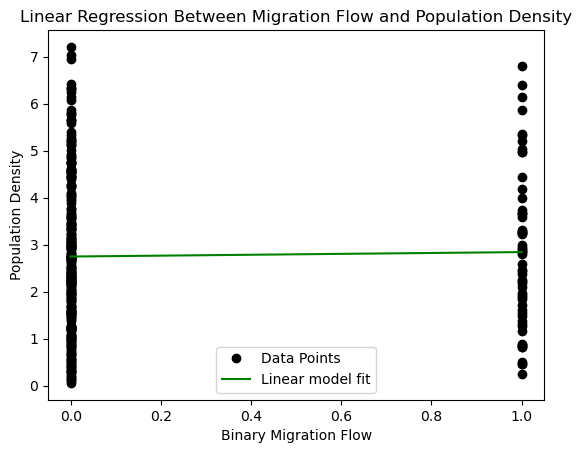

In [19]:
X_d = np.c_[np.ones(len(sum_cases_by_county)), sum_cases_by_county['mig flow_binary']]
y_d = sum_cases_by_county['pd']

X_d = sm.add_constant(X_d)  
model = sm.OLS(y_d, X_d).fit()
INTERCEPT2, SLOPE2 = model.params[0], model.params[1]

tempx2 = [0, 1]
plotting_temp2 = [SLOPE2 * x + INTERCEPT2 for x in tempx2]

plt.plot(sum_cases_by_county['mig flow_binary'], sum_cases_by_county['pd'], 'ko')
plt.plot(tempx2, plotting_temp2, 'g-')

plt.ylabel('Population Density')
plt.xlabel('Binary Migration Flow')
plt.title('Linear Regression Between Migration Flow and Population Density')
plt.legend(['Data Points', 'Linear model fit'])

plt.show()


In [20]:
X_density = sum_cases_by_county['pd']
X_density = sm.add_constant(X_density)

model_density = sm.OLS(y_d, X_density).fit()

print("Linear Regression for 'population density' vs 'roi'")
print(model_density.summary())

Linear Regression for 'population density' vs 'roi'
                            OLS Regression Results                            
Dep. Variable:                     pd   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.531e+32
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:23:59   Log-Likelihood:                 10615.
No. Observations:                 321   AIC:                        -2.123e+04
Df Residuals:                     319   BIC:                        -2.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
